# 02 - Format Open Image Annotation for Detectron2

In this notebook we will convert Open Image annotation to a format that Detectron2 can read and visualize.

In [1]:
%cd open-images-v5

/mnt/data/object_detection/open-images-v5


**Resources:**
- [Detectron2's guide to use custom dataset](https://detectron2.readthedocs.io/tutorials/datasets.html)
- [Detectron2's Colab tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)

For standard tasks (instance detection, instance/semantic/panoptic segmentation, keypoint detection), we load the original dataset into list[dict] with a specification similar to COCO’s json annotations. Below is an example:

```json
# Example of Detectron2 dataset dict for image "1e2c50b991a82ee8.jpg"
{'file_name': 'images/01284dd8eaad0569.jpg',
 'image_id': '01284dd8eaad0569',
 'height': 1024,
 'width': 1024,
 'annotations': [{'bbox': [298.0, 329.0, 778.0, 1024.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1},
  {'bbox': [105.0, 54.0, 896.0, 307.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}
```

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [3]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im), plt.axis('off');

When downloading images, images of each class were saved in a separate folder:

```
train/
    Camera/
    Tripod/
validation/
    Camera/
    Tripod/
```

Because we already have annotation files which have information about train/val split and classes, we can put all images into the same folder for easier processing.

```bash
# Move images in subfolders to one folder
for folder in ['train', 'validation']:
    !mkdir -p images
    !mv $folder/Camera/* images
    !rmdir $folder/Camera
    !mv $folder/Tripod/* images
    !rmdir $folder/Tripod
```

In [4]:
# Specify target classes and create `class2id` dict
target_classes = ['Camera', 'Tripod']
class2id = {k: v for v, k in enumerate(target_classes)}
print(class2id)

# Get LabelName of target classes
classes = pd.read_csv("class-descriptions-boxable.csv", header=None, names=['LabelName', 'Class'])
subset_classes = classes[classes['Class'].isin(target_classes)]
subset_classes

{'Camera': 0, 'Tripod': 1}


,LabelName,Class
370,/m/073bxn,Tripod
498,/m/0dv5r,Camera


Here we create subsets of annotation dataframes which only contain our target classes. It helps loading annotations faster.

In [5]:
# Prepare annotation files
for folder in ['train', 'validation']:
    # Load data
    annot_df = pd.read_csv(f"{folder}-annotations-bbox.csv")
    # Inner join to keep only target classes
    annot_df = annot_df.merge(subset_classes, on='LabelName')
    # Create `ClassID` column
    annot_df['ClassID'] = annot_df['Class'].apply(lambda x: class2id[x])
    # Save truncated annot_df
    annot_df.to_csv(f"{folder}-annotations-bbox-truncated.csv", index=False)
    del annot_df

Function `get_detectron_dicts` takes an annotation dataframe and returns a `list[dict]` to register and load Detectron2 dataset.

In [5]:
def denormalize_bboxes(bboxes, height, width):
    """Denormalize bounding boxes in format of (xmin, ymin, xmax, ymax)."""
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * width
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * height
    return np.round(bboxes)

def get_detectron_dicts(annot_df):
    """
    Create Detectron2's standard dataset from an annotation file.
    
    Args:
        annot_df (pd.DataFrame): annotation dataframe.
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Get image ids
    img_ids = annot_df["ImageID"].unique().tolist()
    
    dataset_dicts = []
    for img_id in tqdm(img_ids):
        file_name = f'images/{img_id}.jpg'
        if not os.path.exists(file_name):
            continue
            
        height, width = cv2.imread(file_name).shape[:2]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[['XMin', 'YMin', 'XMax', 'YMax']][annot_df['ImageID'] == img_id].values
        bboxes = denormalize_bboxes(bboxes, height, width)
        class_ids = annot_df[['ClassID']][annot_df['ImageID'] == img_id].values
        
        annots = []
        for i, bbox in enumerate(bboxes.tolist()):
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(class_ids[i]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

Register datasets:

In [6]:
# Load subset annotations
train_df = pd.read_csv("train-annotations-bbox-truncated.csv")
val_df = pd.read_csv("validation-annotations-bbox-truncated.csv")

# Register dataset with Detectron2
DatasetCatalog.register("camera_tripod_train", lambda d: get_detectron_dicts(train_df))
MetadataCatalog.get("camera_tripod_train").set(thing_classes=target_classes)
DatasetCatalog.register("camera_tripod_val", lambda d: get_detectron_dicts(val_df))
MetadataCatalog.get("camera_tripod_val").set(thing_classes=target_classes)

# Get metadata. It helps show class labels when we visualize bounding boxes
camera_tripod_metadata = MetadataCatalog.get("camera_tripod_train")

Load validation dataset:

In [7]:
dataset_dicts = get_detectron_dicts(val_df)
dataset_dicts[0]

100%|██████████| 166/166 [00:02<00:00, 64.30it/s]


{'file_name': 'images/01284dd8eaad0569.jpg',
 'image_id': '01284dd8eaad0569',
 'height': 1024,
 'width': 1024,
 'annotations': [{'bbox': [298.0, 329.0, 778.0, 1024.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1},
  {'bbox': [105.0, 54.0, 896.0, 307.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}

Now we can visualize bounding boxes using Detectron2's `Visualizer` class.

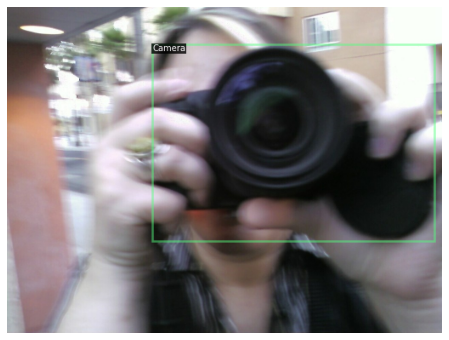

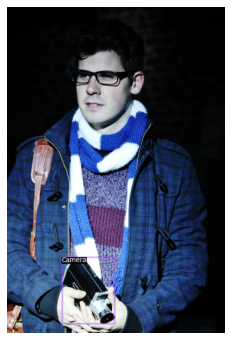

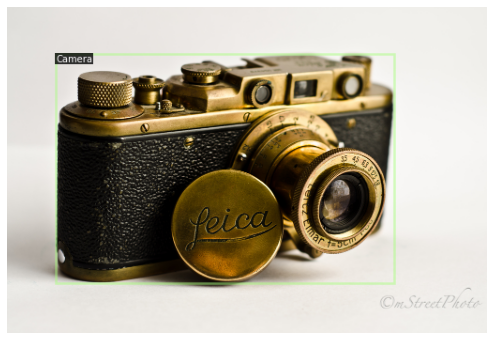

In [8]:
for d in random.sample(dataset_dicts, 3):
    plt.figure()
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=camera_tripod_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1]);